## Library import

In [1]:
import re
from bs4 import BeautifulSoup
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import MapType, StringType, IntegerType, ArrayType, DoubleType, StructType, StructField, FloatType

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import IDF as MLIDF
from pyspark.ml.feature import HashingTF as MLHashingTF
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Creating Spark Session

In [2]:
import socket
LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [3]:
spark = (
    SparkSession
    .builder
    .master('k8s://https://10.32.7.103:6443')
    .config('spark.driver.host', LOCAL_IP)
    .config('spark.driver.bindAddress', '0.0.0.0')
    .config('spark.executor.instances', '3')
    .config('spark.executor.cores', '2')
    .config('spark.cores.max', '4')
    .config('spark.executor.memory', '4g')
    .config('spark.sql.execution.arrow.enabled', 'true')
    .config('spark.kubernetes.namespace', 'akuzmin-337762')
    .config('spark.kubernetes.container.image', 'node03.st:5000/spark-executor:akuzmin-337762')
    .config('spark.kubernetes.container.image.pullPolicy', 'Always')
    .config('spark.kubernetes.executor.deleteOnTermination', 'false')
    .getOrCreate()
)

In [4]:
sc = spark.sparkContext

In [13]:
!ls -lah /home/jovyan/nfs-home/

total 175M
drwxr-xr-x. 16 akuzmin-337762 akuzmin-337762 4.0K Jun 27 13:36  .
drwsrwsr-x.  1 akuzmin-337762 akuzmin-337762  126 Jun 11 12:03  ..
-rw-r--r--.  1 akuzmin-337762 akuzmin-337762 108K Jun 27 13:36  Course_project.ipynb
drwxr-xr-x.  7 akuzmin-337762 akuzmin-337762 4.0K Jun 12 11:02  DAWG-Python-0.7.2
-rw-r--r--.  1 akuzmin-337762 akuzmin-337762 5.3K Jun 14 13:02  dawg_python.zip
drwxr-xr-x.  8 akuzmin-337762 akuzmin-337762 4.0K Jun 12 11:00  docopt-master
-rw-r--r--.  1 akuzmin-337762 akuzmin-337762  36K Jun 13 13:14  docopt-master.zip
-rw-r--r--.  1 akuzmin-337762 akuzmin-337762  38M Jun 13 13:35  gen_natasha.zip
drwxr-xr-x.  7 akuzmin-337762 akuzmin-337762 4.0K Jun 12 11:15  intervaltree-3.1.0
-rw-r--r--.  1 akuzmin-337762 akuzmin-337762  17K Jun 13 13:07  intervaltree.zip
drwxr-xr-x.  8 akuzmin-337762 akuzmin-337762 4.0K Jun 12 11:13  ipymarkup-0.9.0
-rw-r--r--.  1 akuzmin-337762 akuzmin-337762  11K Jun 13 13:06  ipymarkup.zip
drwxr-xr-x.  2 akuzmin-337762 akuzmin-337762 4.

In [5]:
sc.addPyFile('/home/jovyan/nfs-home/natasha.zip')
sc.addPyFile('/home/jovyan/nfs-home/navec.zip')
sc.addPyFile('/home/jovyan/nfs-home/yargy.zip')
sc.addPyFile('/home/jovyan/nfs-home/slovnet.zip')
sc.addPyFile('/home/jovyan/nfs-home/razdel.zip')
sc.addPyFile('/home/jovyan/nfs-home/pymorphy2.zip')
sc.addPyFile('/home/jovyan/nfs-home/dawg_python.zip')
sc.addPyFile('/home/jovyan/nfs-home/intervaltree.zip')
sc.addPyFile('/home/jovyan/nfs-home/ipymarkup.zip')
sc.addPyFile('/home/jovyan/nfs-home/docopt-master.zip')
sc.addPyFile('/home/jovyan/nfs-home/navec_hudlit_v1_12B_500K_300d_100q.tar')
sc.addPyFile('/home/jovyan/nfs-home/pymorphy2-dicts-ru/dist/pymorphy2_dicts_ru-2.4.417127.4579844-py3.8.egg')

In [6]:
import pymorphy2
from navec import Navec
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 

stop_words = stopwords.words("russian")
path = '/home/jovyan/nfs-home/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)
stemmer = SnowballStemmer("russian") 

In [60]:
#!python setup.py install --user

running install
running bdist_egg
running egg_info
writing natasha.egg-info/PKG-INFO
writing dependency_links to natasha.egg-info/dependency_links.txt
writing requirements to natasha.egg-info/requires.txt
writing top-level names to natasha.egg-info/top_level.txt
reading manifest file 'natasha.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching '.git'
writing manifest file 'natasha.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/natasha
copying build/lib/natasha/record.py -> build/bdist.linux-x86_64/egg/natasha
copying build/lib/natasha/syntax.py -> build/bdist.linux-x86_64/egg/natasha
creating build/bdist.linux-x86_64/egg/natasha/grammars
copying build/lib/natasha/grammars/money.py -> build/bdist.linux-x86_64/egg/natasha/grammars
copying build/lib/natasha/grammars/name.py -> build/bdist

In [7]:
spark

## Reading initial dataset

In [9]:
df = spark.read.parquet("/tmp/akuzmin-337762/project/dataset.parquet")

In [47]:
df.select('annotation',F.col('genres.genre.@title').alias('genre')).where('annotation is NULL or genre is NULL').show(5)

+--------------------+---------+
|          annotation|    genre|
+--------------------+---------+
|<p>Свадебное путе...|     null|
|                null|[мистика]|
|                null|[мистика]|
|                null|[мистика]|
|                null|[мистика]|
+--------------------+---------+
only showing top 5 rows



In [261]:
df.printSchema()

root
 |-- @adult: string (nullable = true)
 |-- @allow_full_free: string (nullable = true)
 |-- @allow_read: string (nullable = true)
 |-- @allow_sell: string (nullable = true)
 |-- @art_cover: string (nullable = true)
 |-- @art_cover_h: string (nullable = true)
 |-- @art_cover_w: string (nullable = true)
 |-- @available: string (nullable = true)
 |-- @available_date: string (nullable = true)
 |-- @can_preorder: string (nullable = true)
 |-- @chars: string (nullable = true)
 |-- @contract_author: string (nullable = true)
 |-- @contract_ends: string (nullable = true)
 |-- @contract_title: string (nullable = true)
 |-- @copyright_read_online: string (nullable = true)
 |-- @cover: string (nullable = true)
 |-- @cover_h: string (nullable = true)
 |-- @cover_w: string (nullable = true)
 |-- @created: string (nullable = true)
 |-- @date_written_d: string (nullable = true)
 |-- @date_written_s: string (nullable = true)
 |-- @drm: string (nullable = true)
 |-- @external_id: string (nullable = 

In [12]:
#extracting distinect not null annotations and genres
a_g = (df.select('annotation',F.col('genres.genre.@title').alias('genre'))
       .where(F.col('annotation').isNotNull() & F.col('genre').isNotNull())
       .distinct()
       .cache())

In [54]:
a_g.take(1)

[Row(annotation='<p>Ингвар Кампрад\xa0– шведский предприниматель и основатель компании IKEA. Он сделал то, что до него не удавалось никому на свете: благодаря его стараниям почти у каждого появилась возможность иметь красивый и стильный дом. Но по-настоящему великим его сделали не деньги, а убеждения.</p>\n<p>Ингвар верил, что у всех людей одинаковые базовые потребности, а потому и относиться ко всем нужно одинаково. Он был настоящим лидером, который трудился ради того, чтобы как можно больше людей жили лучше.</p>', genre=['биографии и мемуары', 'зарубежная публицистика', 'мотивация'])]

## Preprocessing functions

In [39]:
#function to remove html-tags
def remove_tags(html):
    soup = BeautifulSoup(html,"html.parser")
    for data in soup(['style', 'script']):
        data.decompose()
  
    return ' '.join(soup.stripped_strings)

In [42]:
#preprocessing function for annotations and genres
def preprocess(line):
    morph = pymorphy2.MorphAnalyzer(lang='ru')
    line= remove_tags(line) # removing html-tags
    tokens = re.sub(r'[\W\d]', ' ', line).split() #removing non-words and tokenization
    return [morph.parse(token)[0][2] for token in tokens if morph.parse(token)[0][2] not in stop_words] #lemmatization and stop-words removing

prep = F.udf(preprocess, ArrayType(StringType())) 

In [43]:
#function to leave only the first genre in the list
def leave_first(genres):
    return ' '.join(preprocess(genres[0]))
leaveFunc = F.udf(leave_first,returnType=StringType())

## Annotation processing: tf-idf approach

In [49]:
anns_tfidf = a_g.select('annotation','genre')

In [50]:
anns_tfidf = anns_tfidf.select(prep('annotation').alias('annotation'),leaveFunc('genre').alias('genre'))

In [56]:
anns_tfidf.show(10)

+--------------------+--------------------+
|          annotation|               genre|
+--------------------+--------------------+
|[осторожно, горяч...|         стих поэзия|
|[задача, каждый, ...|         стих поэзия|
|[книга, основать,...|исторический лите...|
|[скромный, девушк...|иронический детектив|
|[жизнь, заканчива...|     русский фэнтези|
|[сказочный, чудо,...|       детский проза|
|[произведение, ра...|   боевой фантастика|
|[детство, родител...|    любовный фэнтези|
|[законь, термодин...|научно популярный...|
|[дмитрий, журавлё...|классический дете...|
+--------------------+--------------------+
only showing top 10 rows



In [17]:
# Function which returns dataset with calculates tf-idfs
def tf_idf(documents):

    htf = MLHashingTF(inputCol="annotation", outputCol="tf")
    tf = htf.transform(documents)
    tf.cache()
    
    idf = MLIDF(inputCol="tf", outputCol="idf")
    tfidf = idf.fit(tf).transform(tf)
    tf.unpersist()
    
    return tfidf

In [18]:
tfidf = tf_idf(anns_tfidf)

In [11]:
tfidf = spark.read.parquet("/tmp/akuzmin-337762/project/tfidf.parquet")

In [61]:
tfidf.take(5)

[Row(annotation=['the', 'elites', 'of', 'the', 'west', 'want', 'to', 'introduce', 'mechanisms', 'of', 'democracy', 'among', 'traditional', 'peoples', 'and', 'do', 'not', 'know', 'that', 'these', 'mechanisms', 'are', 'immediately', 'used', 'for', 'tradition', 'many', 'people', 'stop', 'looking', 'at', 'who', 'is', 'nobler', 'than', 'their', 'ancestors', 'and', 'start', 'competing', 'for', 'money'], genre='прочий образовательный литература', tf=SparseVector(262144, {4167: 1.0, 9589: 1.0, 16004: 1.0, 22575: 1.0, 27576: 1.0, 39455: 1.0, 48448: 1.0, 55311: 1.0, 58267: 1.0, 80393: 1.0, 94822: 1.0, 95889: 2.0, 106776: 2.0, 106841: 1.0, 107559: 1.0, 114038: 1.0, 115994: 1.0, 134711: 1.0, 140931: 1.0, 143741: 1.0, 160141: 1.0, 161061: 1.0, 163000: 1.0, 168632: 1.0, 185559: 1.0, 187114: 1.0, 190256: 1.0, 202268: 1.0, 204253: 1.0, 216850: 1.0, 219087: 2.0, 219915: 2.0, 221345: 1.0, 221693: 1.0, 232233: 2.0, 245044: 1.0, 247995: 1.0}), idf=SparseVector(262144, {4167: 8.963, 9589: 10.2047, 16004: 7

Vectorization of annotation approach

In [267]:
# Function to make word2vec vectors from string
def vectorize(text):
    vect_words = []
    if (type(text)==type('string')):
        text = text.split()
    for word in text:
        if (word in navec.vocab):
            vect_words.append(navec[word])
    if (len(vect_words)!=0):
        return Vectors.dense(sum(vect_words)/len(vect_words))
vect = F.udf(vectorize,returnType=VectorUDT())

In [57]:
vect_dataset = a_g.select(F.col('annotation').alias('original'),vect('annotation').alias('annotation'),'genre').where('annotation is NOT NULL')

In [58]:
vect_dataset.show(5)

+--------------------+--------------------+--------------------+
|            original|          annotation|               genre|
+--------------------+--------------------+--------------------+
|[осторожно, горяч...|[-0.1674173623323...|         стих поэзия|
|[задача, каждый, ...|[0.01362182665616...|         стих поэзия|
|[книга, основать,...|[-0.1034445315599...|исторический лите...|
|[скромный, девушк...|[-0.0132383694872...|иронический детектив|
|[жизнь, заканчива...|[-0.1268947124481...|     русский фэнтези|
+--------------------+--------------------+--------------------+
only showing top 5 rows



## Preprocessing of genres

In [35]:
vect_genre_dataset = a_g.select(leaveFunc('genre').alias('genre'))

In [45]:
vect_genre_dataset = vect_genre_dataset.select(F.col('genre').alias('original'),vect('genre').alias('genre')).where('genre is NOT NULL').distinct().cache()

In [48]:
vect_genre_dataset.orderBy('genre').show(10)

+----------------+--------------------+
|        original|               genre|
+----------------+--------------------+
|    недвижимость|[-0.7569200396537...|
|делопроизводство|[-0.6689559817314...|
|толковый словарь|[-0.6507665514945...|
|      богословие|[-0.6365396380424...|
|         акафист|[-0.6365396380424...|
|  афоризм цитата|[-0.6297910213470...|
|         сборник|[-0.6249534487724...|
|       попаданец|[-0.5769983530044...|
|    книга вампир|[-0.5541301369667...|
|      справочник|[-0.5377985835075...|
+----------------+--------------------+
only showing top 10 rows



In [358]:
vect_genre_dataset.count()

573

In [9]:
vect_genre_dataset = spark.read.parquet("/tmp/akuzmin-337762/project/genres_encoded.parquet")

In [28]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='genre',predictionCol='prediction').setK(20).setDistanceMeasure('cosine').setMaxIter(50)
model = kmeans.fit(vect_genre_dataset)

# Make predictions
predictions = model.transform(vect_genre_dataset)

# Get coordinates of the cluster centers
centers = model.clusterCenters()

In [29]:
# Performing PCA to visualize the genre clusters
pca = PCAml(k=2, inputCol="genre", outputCol="pca")
pca_model = pca.fit(predictions)
pca_transformed = pca_model.transform(predictions)

In [13]:
# Function to draw clusters
def visualize_clusters(cluster_content):

    k = len(cluster_content.select('prediction').distinct().collect())
    plt.grid() 
    plt.xlabel("x")    
    plt.ylabel("y")

    for i in range(k):
        x_coordinates = []
        y_coordinates = []
        inter_df = cluster_content.where(F.col('prediction')==i)
        for row in inter_df.collect():
            x_coordinates.append(row[0][0])
            y_coordinates.append(row[0][1])
        plt.scatter(x_coordinates, y_coordinates)
    plt.show()

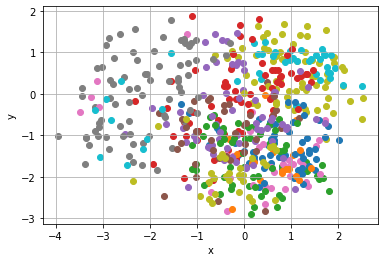

In [40]:
visualize_clusters(pca_transformed.select('pca','prediction'))

In [33]:
genres_transformed = model.transform(vect_genre_dataset).select("original", "prediction")

In [60]:
genres_transformed.where(F.col('prediction')==4).collect()

[Row(original='магия колдовство', prediction=4),
 Row(original='даосизм конфуцианство', prediction=4),
 Row(original='йога', prediction=4),
 Row(original='индийский религия', prediction=4),
 Row(original='мистика', prediction=4),
 Row(original='слияние поглощение', prediction=4),
 Row(original='религия верование культ', prediction=4),
 Row(original='дзэн буддизм', prediction=4),
 Row(original='вероучение буддизм', prediction=4),
 Row(original='эзотерика оккультизм', prediction=4),
 Row(original='практический эзотерика', prediction=4),
 Row(original='спиритизм пророчество предсказание', prediction=4)]

In [56]:
genres_transformed.groupBy('prediction').count().orderBy('prediction').collect()

[Row(prediction=0, count=21),
 Row(prediction=1, count=7),
 Row(prediction=2, count=18),
 Row(prediction=3, count=33),
 Row(prediction=4, count=12),
 Row(prediction=5, count=10),
 Row(prediction=6, count=32),
 Row(prediction=7, count=41),
 Row(prediction=8, count=70),
 Row(prediction=9, count=35),
 Row(prediction=10, count=39),
 Row(prediction=11, count=13),
 Row(prediction=12, count=44),
 Row(prediction=13, count=35),
 Row(prediction=14, count=52),
 Row(prediction=15, count=26),
 Row(prediction=16, count=5),
 Row(prediction=17, count=38),
 Row(prediction=18, count=32),
 Row(prediction=19, count=10)]

## Model training (tf-idf)

In [34]:
res_df = (tfidf.join(genres_transformed,on=[tfidf.genre==genres_transformed.original])
          .select('annotation','genre',F.col('prediction').alias('label'),'tf','idf')).cache()

In [355]:
res_df.show(5)

+--------------------+--------------------+-----+--------------------+--------------------+
|          annotation|               genre|label|                  tf|                 idf|
+--------------------+--------------------+-----+--------------------+--------------------+
|[the, elites, of,...|прочий образовате...|    3|(262144,[4167,958...|(262144,[4167,958...|
|[каждый, произвед...|     русский фэнтези|    3|(262144,[10293,12...|(262144,[10293,12...|
|[секрет, юридичес...|          справочник|    3|(262144,[16548,25...|(262144,[16548,25...|
|[сколько, год, ве...|   книга путешествие|    3|(262144,[17812,17...|(262144,[17812,17...|
|[книга, рассмотре...|            здоровье|    0|(262144,[340,7492...|(262144,[340,7492...|
+--------------------+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



In [29]:
res_df.select('annotation').distinct().count()

330490

In [35]:
# Splitting preprocessed data into train|test 
(trainingData, testData) = res_df.randomSplit([0.7, 0.3], seed = 100)

In [6]:
trainingData = spark.read.parquet("/tmp/akuzmin-337762/project/trainingData.parquet")
testData = spark.read.parquet("/tmp/akuzmin-337762/project/testData.parquet")

In [36]:
# Training Naive Bayes model
nb = NaiveBayes(smoothing=1,featuresCol='idf', labelCol='label', predictionCol='prediction')
model = nb.fit(trainingData.dropDuplicates(['annotation']))
print('fitting done')
predictions = model.transform(testData.dropDuplicates(['annotation']))

fitting done


In [37]:
# Calculating classification metrics
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Accuracy = ',evaluator.evaluate(predictions))
evaluator.setMetricName('fMeasureByLabel')
print('F-measure = ',evaluator.evaluate(predictions))
evaluator.setMetricName("precisionByLabel")
print('Precision = ',evaluator.evaluate(predictions))
evaluator.setMetricName("recallByLabel")
print('Recall = ',evaluator.evaluate(predictions))

Accuracy =  0.4695987260903687
F-measure =  0.34084231145935356
Precision =  0.2600896860986547
Recall =  0.4943181818181818


In [38]:
# Training random forest classifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="idf", \
                            numTrees = 15, \
                            maxDepth = 30, \
                            maxBins = 16)

rfModel = rf.fit(trainingData)
print('fitting done')
predictions = rfModel.transform(testData)

fitting done


In [11]:
predictions.select('label','prediction').where('label==prediction').count()

22861

In [39]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Accuracy = ',evaluator.evaluate(predictions))
evaluator.setMetricName('fMeasureByLabel')
print('F-measure = ',evaluator.evaluate(predictions))
evaluator.setMetricName("precisionByLabel")
print('Precision = ',evaluator.evaluate(predictions))
evaluator.setMetricName("recallByLabel")
print('Recall = ',evaluator.evaluate(predictions))

Accuracy =  0.2957328428402132
F-measure =  0.005617977528089888
Precision =  1.0
Recall =  0.0028169014084507044
